In [19]:
import pandas as pd
import os
from pathlib import Path, PureWindowsPath
import numpy as np
from sklearn.cluster import KMeans
from sklearn.preprocessing import MinMaxScaler
import seaborn as sns
import matplotlib.pyplot as plt 

# Load files in

In [2]:
filename_1 = 'FEMA_claims.csv.gz'
filename_2 = 'ASEC_income.csv.gz'
filename_3 = 'ZHVI.csv.gz'
url = Path(PureWindowsPath('C:\\Users\\woodn\\github\\datasets'))
filepath_1 = url / filename_1
filepath_2 = url / filename_2
filepath_3 = url / filename_3

In [3]:
df_fema = pd.read_csv(filepath_1,
                      on_bad_lines = 'warn',
                      low_memory = False
                     )
df_asec = pd.read_csv(filepath_2,
                      on_bad_lines = 'warn',
                      low_memory = False
                     )
df_zhvi = pd.read_csv(filepath_3,
                      on_bad_lines = 'warn',
                      low_memory = False
                     )

# Aggregate FEMA data down to year for y-o-y analysis

In [4]:
df_fema.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20644383 entries, 0 to 20644382
Data columns (total 7 columns):
 #   Column          Dtype  
---  ------          -----  
 0   date            object 
 1   county          object 
 2   state           object 
 3   city            object 
 4   zip             object 
 5   damage          float64
 6   reimbursements  float64
dtypes: float64(2), object(5)
memory usage: 1.1+ GB


In [5]:
df_fema.sample(3)

,date,county,state,city,zip,damage,reimbursements
9882027,2016-04-25,Harris,TX,HOUSTON,77014,1891.0,0.0
10509601,2017-08-25,Harris,TX,PASADENA,77506,0.0,0.0
13732953,2017-09-10,Monroe,FL,KEY WEST,33040,0.0,0.0


In [6]:
try:
    df_fema['year'] = pd.to_datetime(arg=df_fema.loc[:,'date']
                                     ,errors='raise'
                                     ,format="%Y-%m-%d"
                                    ).dt.year
except:
    print('that ain\'t it man')

In [7]:
df_fema.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20644383 entries, 0 to 20644382
Data columns (total 8 columns):
 #   Column          Dtype  
---  ------          -----  
 0   date            object 
 1   county          object 
 2   state           object 
 3   city            object 
 4   zip             object 
 5   damage          float64
 6   reimbursements  float64
 7   year            int64  
dtypes: float64(2), int64(1), object(5)
memory usage: 1.2+ GB


In [8]:
df2_fema = df_fema.groupby(by=['state','county','year'], as_index=False)\
                    .agg(tot_reim = ('reimbursements','sum')
                         ,cnt_req = ('reimbursements','count')
                        ).dropna()

In [9]:
df2_fema.sample(3)

,state,county,year,tot_reim,cnt_req
8962,WI,Shawano,2020,0.0,63
4437,MS,Alcorn,2020,0.0,178
763,CA,Solano,2020,988216.4,1685


In [10]:
df2_fema.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 9198 entries, 0 to 9221
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   state     9198 non-null   object 
 1   county    9198 non-null   object 
 2   year      9198 non-null   int64  
 3   tot_reim  9198 non-null   float64
 4   cnt_req   9198 non-null   int64  
dtypes: float64(1), int64(2), object(2)
memory usage: 431.2+ KB


# Fit a model for each year to cluster into: low,med,high

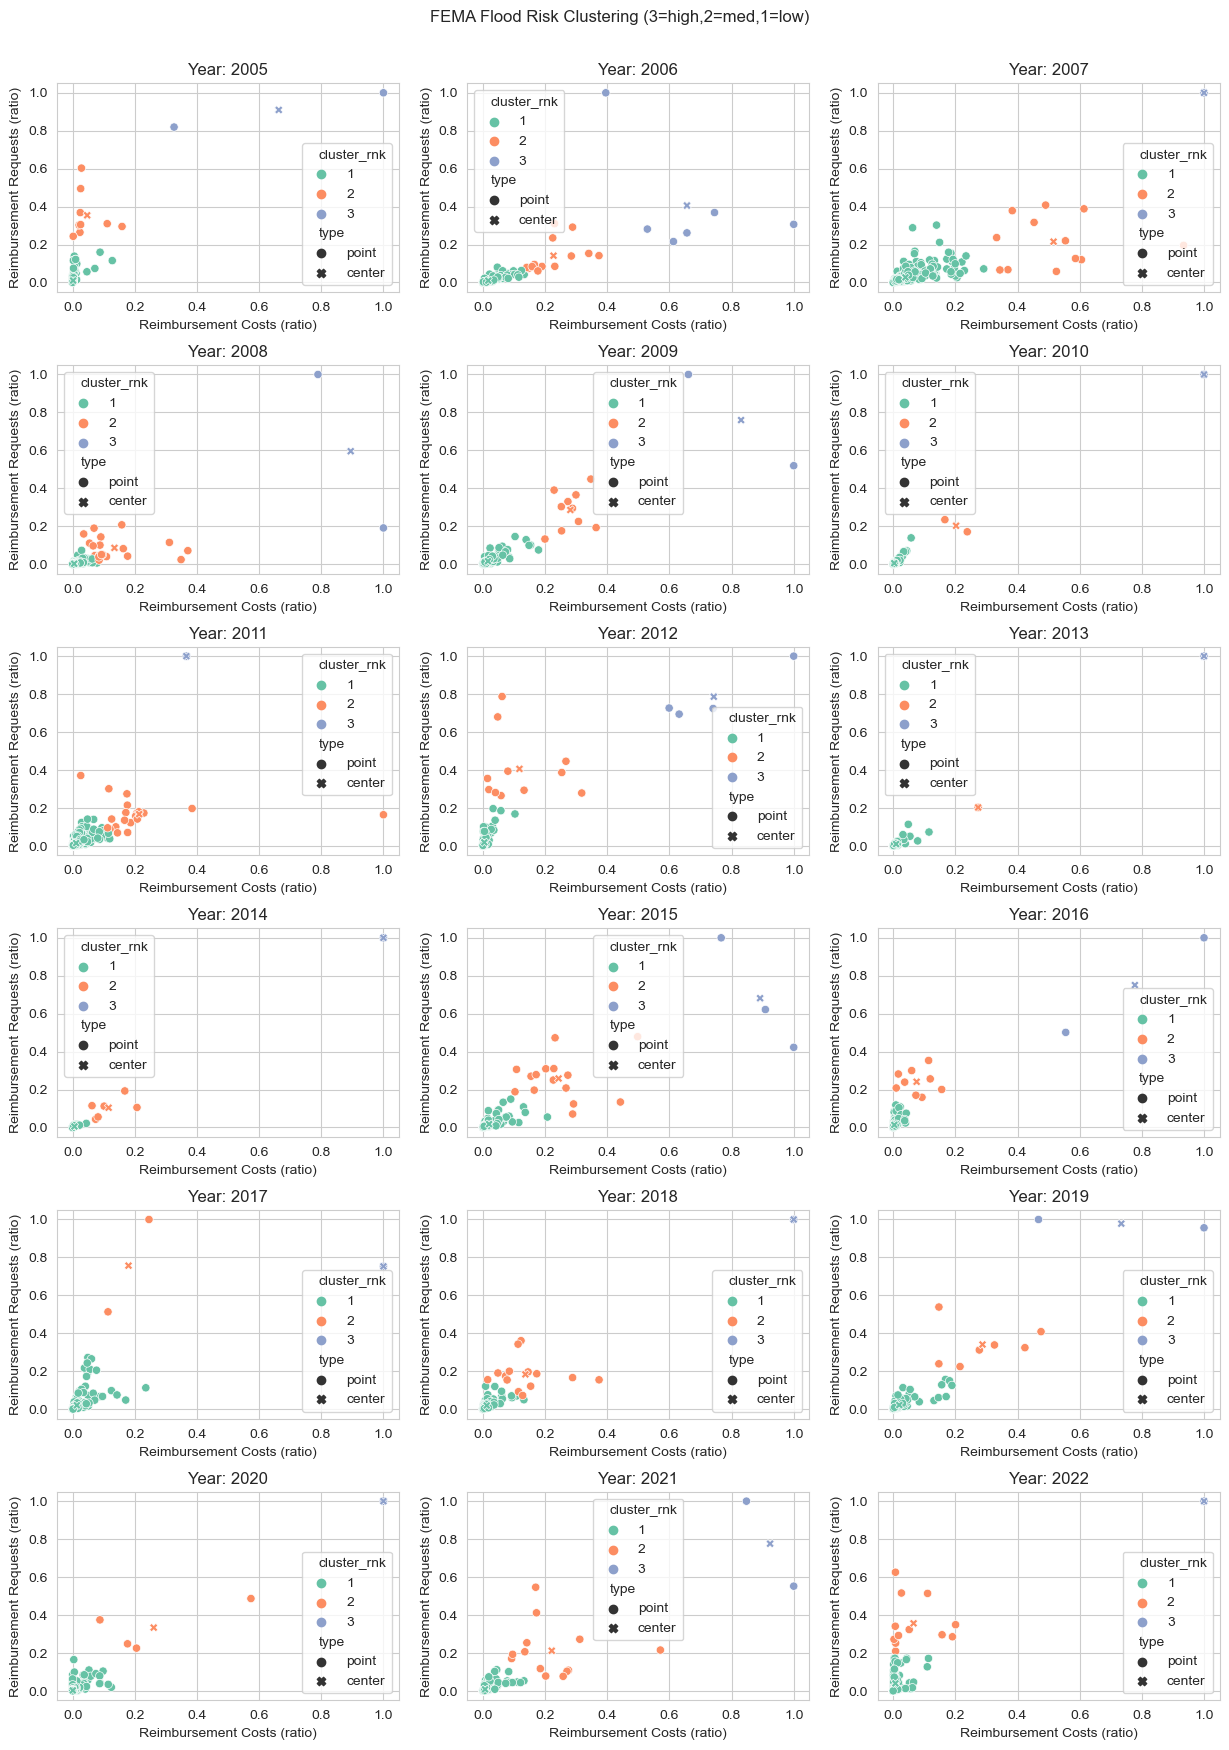

In [54]:
k = 3
h = int(18/k)
fig, ax = plt.subplots(h, k, figsize=(15, h*3.5))
import warnings
warnings.filterwarnings('ignore')

for i,y in enumerate(range(2005,2023)):
    X = pd.DataFrame(
        MinMaxScaler().fit_transform(df2_fema.loc[df2_fema.loc[:,'year']==y,['tot_reim','cnt_req']])
        ,columns=['tot_reim','cnt_req']
    )
    mdl = KMeans(n_clusters=3,n_init='auto').fit(X)
    
    
    X.loc[:,'cluster'] = mdl.labels_
    X = X.astype({'cluster':'int16'})
    X.loc[:,'type'] = 'point'

    X_ = pd.DataFrame(mdl.cluster_centers_
                      ,columns=['tot_reim','cnt_req']
                     )
    X_.loc[:,'cluster'] = pd.Series(np.arange(0,3))
    X_.loc[:,'cluster_l2'] = (X_.loc[:,'tot_reim']**2 + X_.loc[:,'cnt_req']**2)**0.5
    X_.loc[:,'cluster_rnk'] = X_.loc[:,'cluster_l2'].rank().astype({'cluster_l2':'int8'}
                                                                  )
    X_.loc[:,'type'] = 'center'
    
    X = pd.merge(X
                 ,X_.loc[:,['cluster','cluster_rnk']]
                 ,how = 'left'
                 ,left_on = 'cluster'
                 ,right_on = 'cluster'
                 )

    sns.set_style('whitegrid')
    sns.scatterplot(data = pd.concat([X,X_.drop(columns = 'cluster_l2')])
                    ,x = 'tot_reim'
                    ,y = 'cnt_req'
                    ,hue = 'cluster_rnk'
                    ,style = 'type'
                    ,palette = 'Set2'
                    ,ax=ax[int(i/k),i%k]
                   )
    
    ax[int(i/k),i%k].set(ylabel='Reimbursement Requests (ratio)'
                         ,xlabel='Reimbursement Costs (ratio)'
                         ,title = 'Year: {}'.format(str(y))
                        )
fig.subplots_adjust(hspace=0.35,wspace=0.2)
fig.suptitle('FEMA Flood Risk Clustering (3=high,2=med,1=low)',y=0.915)

path = os.path.join(os.getcwd(),'figs')
filename = 'y-o-y_cluster_all' + '.png'

if not os.path.exists(path):
    os.makedirs(path)
plt.savefig(fname=os.path.join(path,filename))